In [1]:
import pandas as pd
import get_data as gd
import matplotlib.pyplot as plt

# Intro to the Data Sets

This notebook will introduce you to some foundational datasets for sabermetrics. An brief overview of the datasets, code to get the data, and some examples of how you can use the dataset to answer baseball questions will be provided.

The datasets introduced will be:
* The Lahman Dataset - It provides a large amount of season data from 1871 to the current season. It has an impressive amount of documentation and can be downloaded in a number of different sources (I use the csv version in this notebook)

## The Lahman Dataset

The section will go over (1) How to get the data to your local (2) Examples of questions you can answer with the data (3) Limitation of the dataset.

### Getting the Data
Neither function is to complex but both help save some time and manual steps. 

The first function "get_data" checks to see if a "master" folder already exists, if it doesn't it then uses the "dload" package to download and unzip all the files. Some potential good extensions to the get_data function would be to allow the user to provide the source link, name of the master file, and the option to update the content of the master file if it already exists.

The "make_df" function just saves you from having to remeber the location of the lahman dataset.

Again neither function is required, but makes life a litte bit easier.

In [2]:
def get_data():
    """
    Function to download lahman data set, unzip and create a folder
    """
    if path.exists('master'):
        print('Folder already exists')
    else:
        dload.save_unzip("https://github.com/chadwickbureau/baseballdatabank/archive/master.zip")


def make_df(data_set: str) -> pd.DataFrame:
    """
    Simple function that saves writting out the file path
    :param data_set: Name of Lahman dataset you want
    :return: A dataframe of the dataset
    """
    assert isinstance(data_set, str)
    df: pd.DataFrame = pd.read_csv(f'master/baseballdatabank-master/core/{data_set}.csv')
    assert isinstance(df, pd.DataFrame)
    return df

### Example Questions & Limitation

Below are some example questions that will be answered, the Lahman dataset provides you with almost everything you need to answer season level questions. However, since all data is aggregated to a season you won't be able to dig into game/event specific questions such as "Do hot streaks exists for batter or pitchers?".

#### Q1 - What is the average number of home runs per game recorded in each decade? Does the rate of strikeouts show any correlation with the rate of home runs?

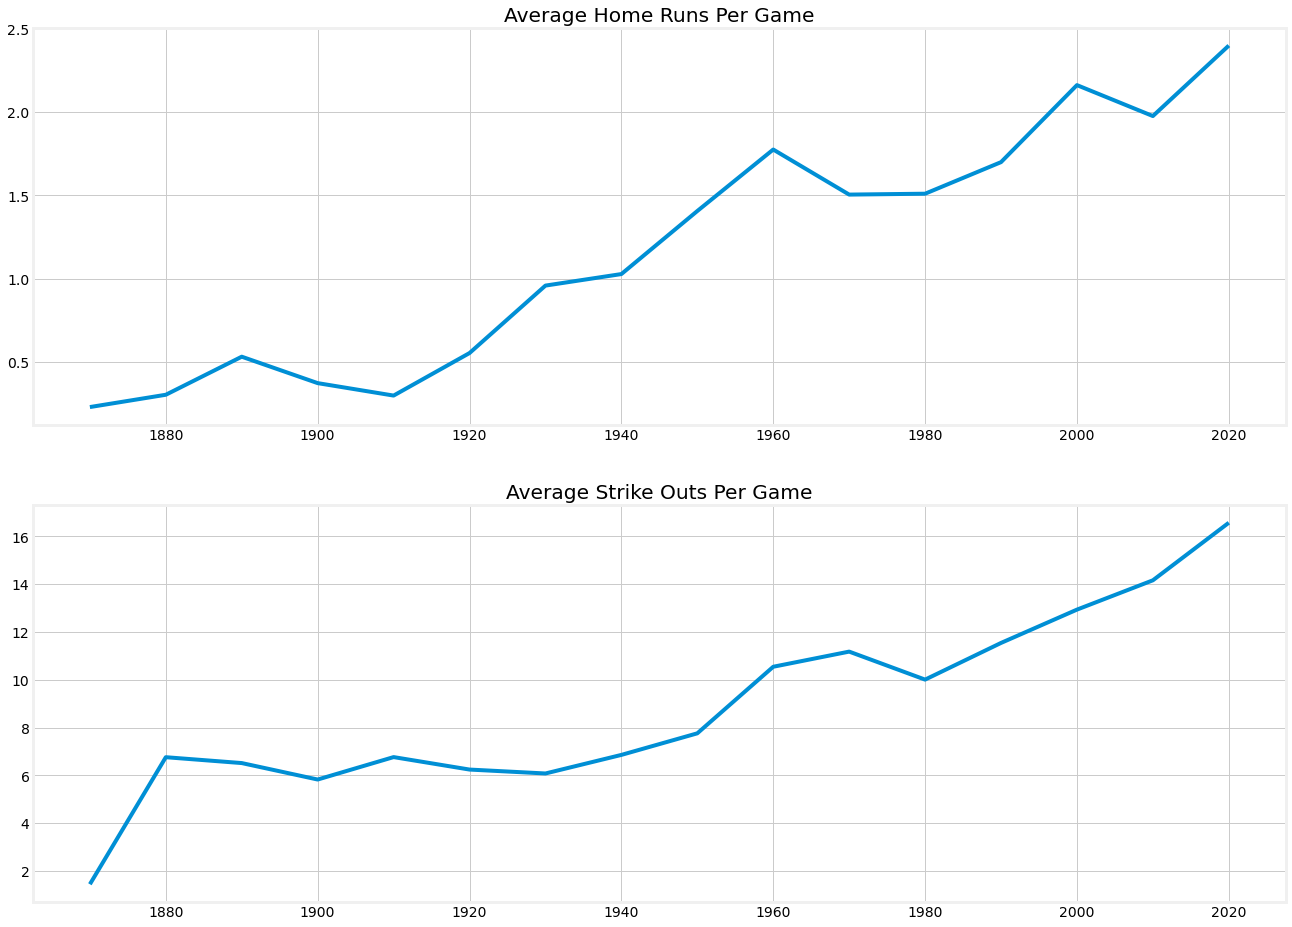

In [12]:
teams_df = gd.make_df("Teams") # Get the Teams data 

# Convert the year into decades
teams_df['decade'] = round(teams_df['yearID']/10)*10 
# Use the groupby function to aggregate totals for G, HR and SO by decade
# I tend to find to easier to set as_index to false
decade_group = teams_df.groupby('decade', as_index=False)[['G','HR','SO']].sum()
#This removes double counting games
decade_group['G'] = decade_group['G']/2 
# Now you just need to calculate the averages by decade :)
decade_group['Avg HR Per Game'] = decade_group['HR']/decade_group['G']
decade_group['Avg SO Per Game'] = decade_group['SO']/decade_group['G']

# I will be using matplotlib, some other good libraries to check out are seaborn, plotly & altair
# As some future work I will re-make these graphs with the other libraries
# Style wise, I typically start with 538, then make some modification to make it with a white background
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(20,15))
# Since we want to compare to different metrics over time I use the gricspec function
# Given the x-axis align and the y-axis don't I find it better to stack the graphs vertically rather than horizontally
# If they are side by side I find ppl tend not to notice the different in axis's 
# As a rule of thumb I try and always align axis of the same time, so in this case both graphs have x-axis that are by decade
gs = fig.add_gridspec(2,1)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])

fig.patch.set_facecolor('white')
ax1.set_facecolor('white')
ax1.plot(decade_group['decade'], decade_group['Avg HR Per Game'])
ax1.set_title('Average Home Runs Per Game')

ax2.set_facecolor('white')
ax2.plot(decade_group['decade'], decade_group['Avg SO Per Game'])
ax2.set_title('Average Strike Outs Per Game')
plt.show()

#### Q2 - What effect has the introduction of the Designated Hitter (DH) in the American League had in the difference in run scoring between the American and National Leagues?

<ipython-input-13-f95b7d090970>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nl_group['Avg Runs Per Game'] = nl_group['R']/nl_group['G']
<ipython-input-13-f95b7d090970>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  al_group['Avg Runs Per Game'] = al_group['R']/al_group['G']


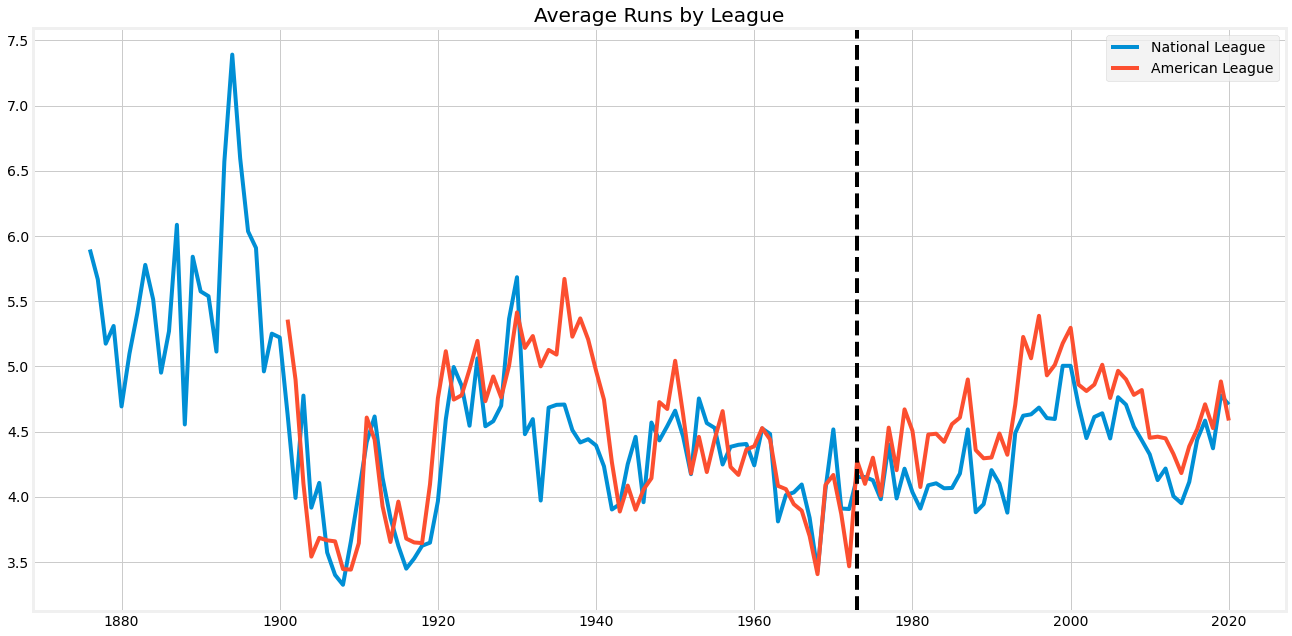

In [13]:
# Similiar to above you can do some simple groupping by league & year for games and runs
league_group = teams_df.groupby(['yearID','lgID'], as_index=False)[['G','R']].sum()

# I then seperate out NL & AL into their own dataframes to make graphing & calculations easier 
nl_group = league_group[league_group['lgID'] == 'NL']
al_group = league_group[league_group['lgID'] == 'AL']

# Find the average runs per game (since we seperated leagues no need to remove double counting)
nl_group['Avg Runs Per Game'] = nl_group['R']/nl_group['G']
al_group['Avg Runs Per Game'] = al_group['R']/al_group['G']


plt.style.use('fivethirtyeight')
# First attempt at graphing this I just plotted the two leagues over top of each other
# This seemed like the natural way to look at it but it was hard to tell what the impact was
fig, ax = plt.subplots(figsize= (20,10))
fig.patch.set_facecolor('white')
ax.plot(nl_group['yearID'], nl_group['Avg Runs Per Game'], label='National League')
ax.plot(al_group['yearID'], al_group['Avg Runs Per Game'], label='American League')
ax.set_facecolor('white')
ax.legend()
ax.set_title('Average Runs by League')
plt.axvline(x=1973, color='black', linestyle='--') # draw a line for when the DH was added to make seeing the impact easier
plt.show()

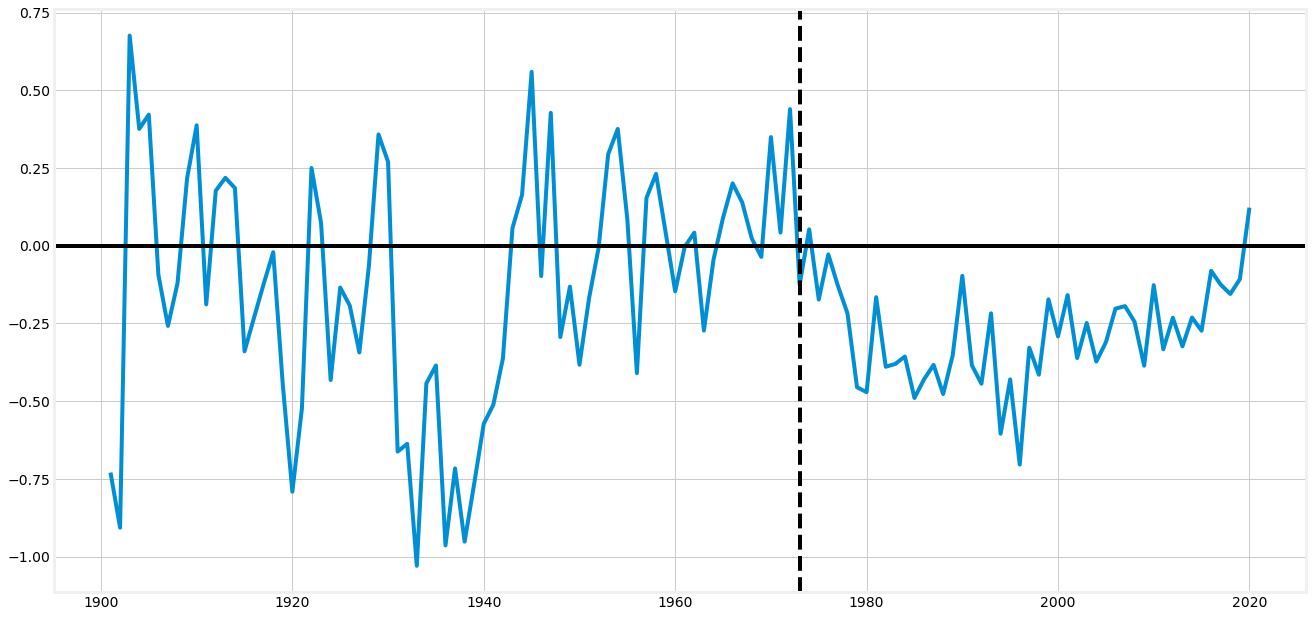

In [14]:
# In my second attempt I merge the AL & NL sets together and then graph the difference
league_merge = pd.merge(nl_group, al_group, on='yearID',suffixes=('_nl', '_al'))
league_merge['Avg Run Difference'] = league_merge['Avg Runs Per Game_nl'] - league_merge['Avg Runs Per Game_al']

# The impact of the DH is more clear to see in this method
# The interesting thing to notice is how slowly how the impact of the DH has disappeared
# This makes me want to dig into what is causing the decline in the impact
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize= (20,10))
fig.patch.set_facecolor('white')
ax.plot(league_merge['yearID'], league_merge['Avg Run Difference'])
ax.set_facecolor('white')
#ax.legend()
plt.axvline(x=1973, color='black', linestyle='--')
plt.axhline(y=0, color='black')
plt.show()

#### Q3 - How does the percentage of games completed by the starting pitcher from 2000 to 2010 compare to the percentage of games 100 years before?

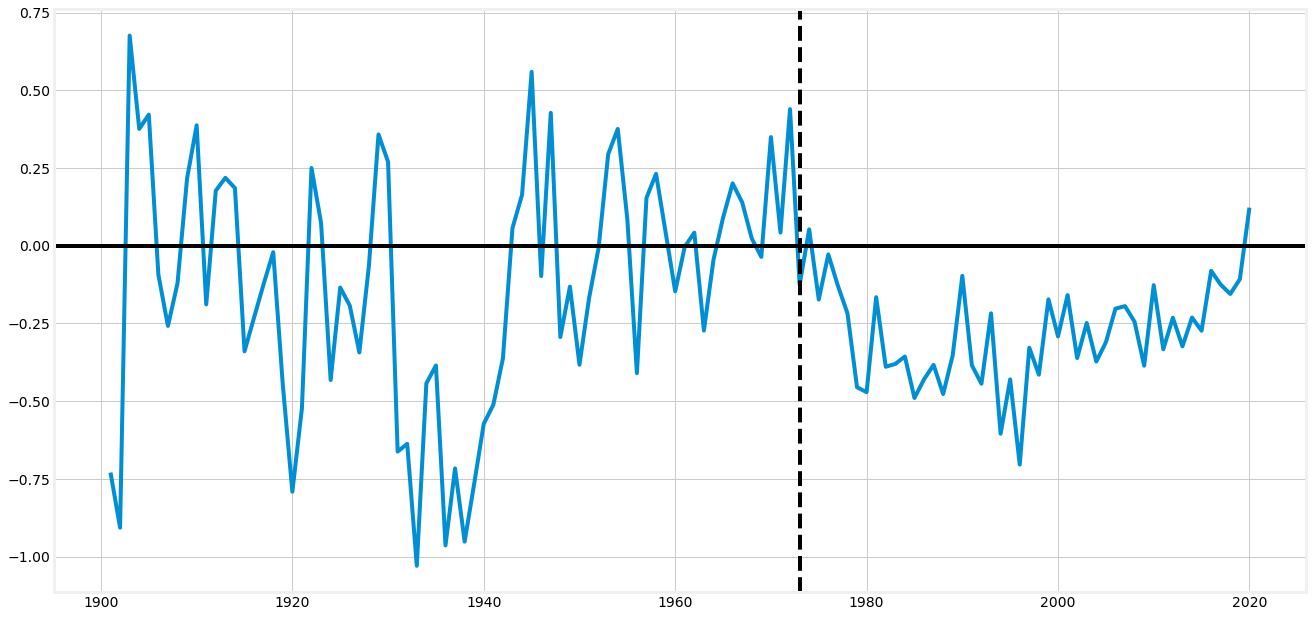